<a href="https://colab.research.google.com/github/seabisilas-alt/Github-Work/blob/main/RQ1_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uninstall and reinstall numpy, pandas, gensim and fasttext
!pip uninstall numpy pandas fasttext -y
!pip install numpy pandas==2.2.2 fasttext tensorflow

Found existing installation: numpy 2.3.3
Uninstalling numpy-2.3.3:
  Successfully uninstalled numpy-2.3.3
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: fasttext 0.9.3
Uninstalling fasttext-0.9.3:
  Successfully uninstalled fasttext-0.9.3
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached fasttext-0.9.3-cp312-cp312-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_hub as hub
import tensorflow as tf
import re
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, RepeatVector, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from collections import Counter

In [ ]:
Domains = pd.read_csv('/content/drive/MyDrive/MSC Work/RQ1/Dataset/All Domains.csv')

/tmp/ipython-input-1272581210.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  Domains = pd.read_csv('/content/drive/MyDrive/MSC Work/RQ1/Dataset/All Domains.csv')


In [ ]:
Domains

,Domains,Label,Ransomware_Family,Binary_Label
0,google.com,Legitimate,NaN,0
1,facebook.com,Legitimate,NaN,0
2,youtube.com,Legitimate,NaN,0
3,baidu.com,Legitimate,NaN,0
4,yahoo.com,Legitimate,NaN,0
...,...,...,...,...
1999995,rbbthoksljqi.com,Malicious,cryptolocker,1
1999996,rrcbkkirjrjt.net,Malicious,cryptolocker,1
1999997,hbjmafnepobj.biz,Malicious,cryptolocker,1
1999998,rsuwpapkvvng.ru,Malicious,cryptolocker,1


In [ ]:
Legitimate_Domains_df = pd.read_csv('/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/Benign Domains.csv', header=None, names=['Legitimate Domain'])

In [ ]:
Legitimate_Domains_df

,Legitimate Domain
1,google.com
2,facebook.com
3,youtube.com
4,baidu.com
5,yahoo.com
...,...
999996,cfre.org
999997,fabricadericos.com
999998,earthrootgaming.com
999999,abusehoster.ru


In [ ]:
# Lowercase
Legitimate_Domains_df['Legitimate Domain'] = Legitimate_Domains_df['Legitimate Domain'].str.lower()

# Split
train_df, test_df = train_test_split(Legitimate_Domains_df, test_size=0.2, random_state=42)



In [ ]:
Illegitimate_Domains_df = pd.read_csv('/content/drive/MyDrive/MSC Work/RQ1/Dataset/Labelled Domains.csv')

In [ ]:
Illegitimate_Domains_df

,Domains,Ransomware_Family,Label
0,cutugmurobi.kz,pushdo,Malicious
1,jakeaveij.kz,pushdo,Malicious
2,diqawupux.kz,pushdo,Malicious
3,vilkugnoknab.kz,pushdo,Malicious
4,peisansuxm.kz,pushdo,Malicious
...,...,...,...
999995,rbbthoksljqi.com,cryptolocker,Malicious
999996,rrcbkkirjrjt.net,cryptolocker,Malicious
999997,hbjmafnepobj.biz,cryptolocker,Malicious
999998,rsuwpapkvvng.ru,cryptolocker,Malicious


In [ ]:
Combined = pd.concat([Illegitimate_Domains_df, Legitimate_Domains_df])

In [ ]:
Combined['Domains'] = Combined['Domains'].fillna(Legitimate_Domains_df['Legitimate Domain'])

In [ ]:
Combined['Label'] = Combined['Label'].replace({'Malicious':'__label__Malicious'})

In [ ]:
Combined['Label'] = Combined['Label'].fillna('__label__Legit')

In [ ]:
Combined

,Domains,Ransomware_Family,Label,Legitimate Domain
0,cutugmurobi.kz,pushdo,__label__Malicious,NaN
1,jakeaveij.kz,pushdo,__label__Malicious,NaN
2,diqawupux.kz,pushdo,__label__Malicious,NaN
3,vilkugnoknab.kz,pushdo,__label__Malicious,NaN
4,peisansuxm.kz,pushdo,__label__Malicious,NaN
...,...,...,...,...
999996,cfre.org,NaN,__label__Legit,cfre.org
999997,fabricadericos.com,NaN,__label__Legit,fabricadericos.com
999998,earthrootgaming.com,NaN,__label__Legit,earthrootgaming.com
999999,abusehoster.ru,NaN,__label__Legit,abusehoster.ru


In [ ]:
Combined['Domains'] = Combined['Domains'].str.lower()


In [ ]:
Training_df, Testing_df = train_test_split(Combined[['Domains', 'Label']], test_size=0.2, random_state=42, stratify=Combined['Label'])

In [ ]:
Training_df['Label'].value_counts()

,count
Label,
__label__Legit,800000
__label__Malicious,800000


## FastText Embeddings

In [ ]:
Training_df['ft'] = Training_df['Label'] + ' ' + Training_df['Domains']

# Save to text files
Training_df['ft'].to_csv("/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/fasttext_train.txt", index=False, header=False)

In [ ]:
model = fasttext.train_supervised(
    input="/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/fasttext_train.txt",
    dim=100,
    minn=2, maxn=5,      # use character n-grams (good for domains)
    lr=0.1,
    epoch=30,
    label="__label__",
    verbose=2
)

In [ ]:
model.save_model("/content/drive/MyDrive/MSC Work/RQ1/FastText_Model/domain_classifier[100].bin")

In [ ]:
FastText_model = fasttext.load_model("/content/drive/MyDrive/MSC Work/RQ1/FastText_Model/domain_classifier[100].bin")

In [ ]:
# Extract domains + labels from test set
test_domains = Testing_df['Domains'].tolist()
test_labels = Testing_df['Label'].tolist()

In [ ]:
def get_FastText_emebddings(domains, model):
    embeddings = []
    for domain in domains:
        embedding = model.get_word_vector(domain)
        embeddings.append(embedding)
    return np.array(embeddings)

In [ ]:
#Get embeddings (vector representations) from FastText
vectors_embeddings = get_FastText_emebddings(test_domains, FastText_model)

In [ ]:
vectors_embeddings

array([[ 0.0134538 , -0.0127011 ,  0.01008348, ..., -0.01554583,
         0.00890035,  0.00303836],
       [ 0.03400434, -0.03209342,  0.02544347, ..., -0.03927373,
         0.02247516,  0.00767317],
       [ 0.03849643, -0.03633389,  0.02879929, ..., -0.0444545 ,
         0.0254386 ,  0.00868791],
       ...,
       [ 0.03302389, -0.03116529,  0.02470322, ..., -0.03814038,
         0.02182317,  0.00745138],
       [ 0.02512365, -0.02371792,  0.0188241 , ..., -0.02902481,
         0.01661746,  0.00567223],
       [-0.01141044,  0.01076262, -0.00853056, ...,  0.01318099,
        -0.00753692, -0.0025704 ]], shape=(400000, 100), dtype=float32)

In [ ]:
# Reduce to 2D
pca = PCA(n_components=2)
PCA_Embeddings = pca.fit_transform(vectors_embeddings)


In [ ]:
clean_labels = [l.replace("__label__", "") for l in test_labels]

In [ ]:
reduced

array([[ 1.1544370e-01,  5.2462456e-06],
       [-3.2725364e-02,  4.1866315e-07],
       [-6.5098420e-02,  1.5614551e-06],
       ...,
       [-2.5634050e-02, -1.9800023e-06],
       [ 3.1245545e-02,  1.0038278e-05],
       [ 2.9482234e-01, -1.5837735e-06]], shape=(400000, 2), dtype=float32)

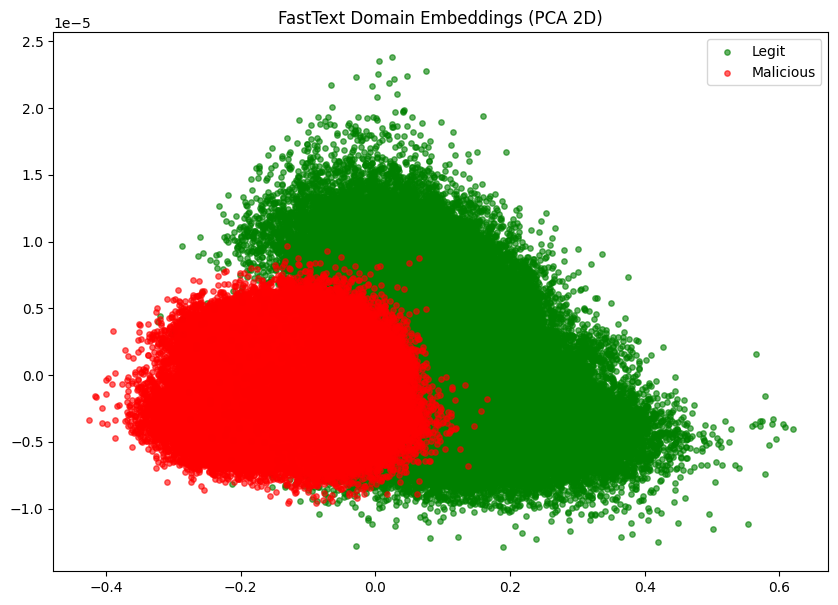

In [ ]:
# Plot
plt.figure(figsize=(10,7))

for label, color in [('Legit', 'green'), ('Malicious', 'red')]:
    idx = [i for i, l in enumerate(clean_labels) if l == label]
    plt.scatter(PCA_Embeddings[idx,0], PCA_Embeddings[idx,1], label=label, alpha=0.6, s=15, c=color)

plt.title("FastText Domain Embeddings (PCA 2D)")
plt.legend()
plt.show()

In [ ]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
reduced = tsne.fit_transform(vectors_embeddings)  # reduced.shape -> (n_samples, 2)

# Plot
plt.figure(figsize=(8,6))
for label, color in [('Legit', 'green'), ('Malicious', 'red')]:
    idx = [i for i, l in enumerate(clean_labels) if l == label]
    plt.scatter(reduced[idx,0], reduced[idx,1], label=label, alpha=0.6, s=20, c=color)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE of Domain Embeddings")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_embeddings)

In [ ]:
cluster_labels

array([0, 1, 1, ..., 1, 0, 0], shape=(400000,), dtype=int32)

In [ ]:
Testing_df

,Domains,Label,Domain_tokens
935255,miraiskirt.com,0,miraiskirt com
331832,7gcq3b1ps5t87rb9vlulax9n1.com,1,7gcq3b1ps5t87rb9vlulax9n1 com
467667,airliftpounddiscoverbeat.com,1,airliftpounddiscoverbeat com
294878,asiaforbet.com,0,asiaforbet com
983852,geekfashion.pl,0,geekfashion pl
...,...,...,...
47686,hohamicno.kz,1,hohamicno kz
578296,ladybodypagegenerateprovide.com,1,ladybodypagegenerateprovide com
560313,waterstablelinkbringwish.com,1,waterstablelinkbringwish com
341662,sbyake.com,0,sbyake com


In [ ]:
Testing_df['Label'] = Testing_df['Label'].replace({'__label__Malicious' : 1, '__label__Legit' : 0})

/tmp/ipython-input-668255655.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Testing_df['Label'] = Testing_df['Label'].replace({'__label__Malicious' : 1, '__label__Legit' : 0})


In [ ]:
Testing_df['Cluster'] = cluster_labels

NameError: name 'cluster_labels' is not defined

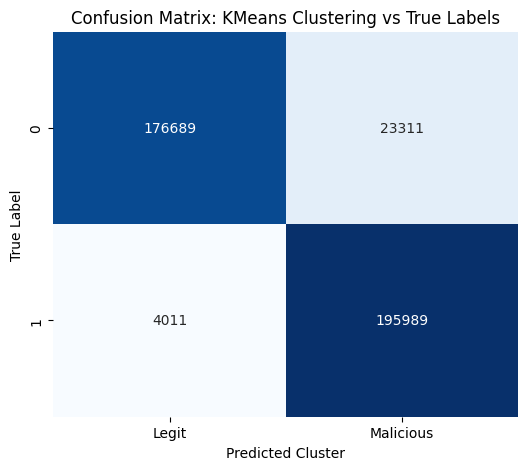

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(Testing_df['Label'], Testing_df['Cluster'])

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Legit", "Malicious"],
            yticklabels=Testing_df['Label'].unique())

plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix: KMeans Clustering vs True Labels")
plt.show()



In [ ]:
print(classification_report(Testing_df['Label'], Testing_df['Cluster']))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93    200000
           1       0.89      0.98      0.93    200000

    accuracy                           0.93    400000
   macro avg       0.94      0.93      0.93    400000
weighted avg       0.94      0.93      0.93    400000



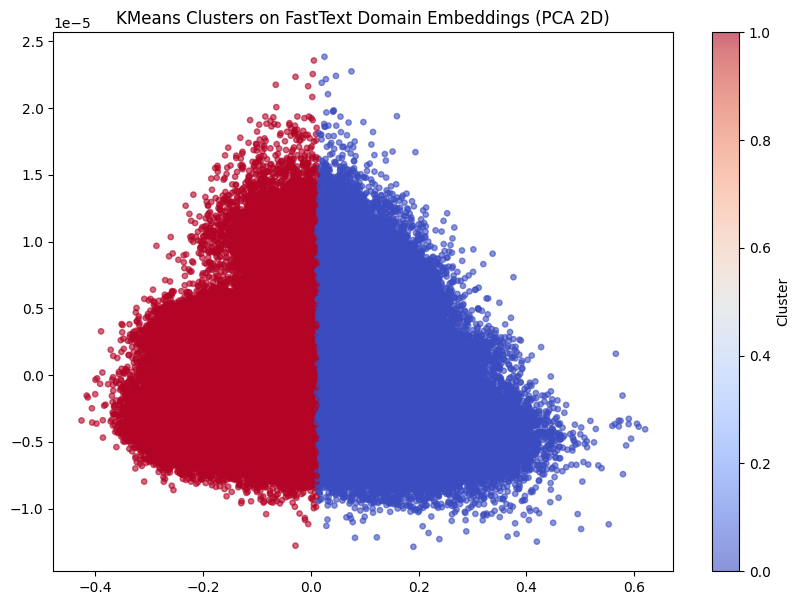

In [ ]:
# Plot clusters
plt.figure(figsize=(10,7))
plt.scatter(reduced[:,0], reduced[:,1], c=cluster_labels, cmap="coolwarm", s=15, alpha=0.6)

# Optional: annotate with domain names (careful if you have too many)
# for i, domain in enumerate(test_domains[:100]):  # annotate first 100 only
#     plt.annotate(domain, (reduced[i,0], reduced[i,1]), fontsize=7, alpha=0.7)

plt.title("KMeans Clusters on FastText Domain Embeddings (PCA 2D)")
plt.colorbar(label="Cluster")
plt.show()

KMeans is perfectly precise for Legit domains → if it says a domain is Legit, you can trust it.

But it misses some Legit domains (lower recall).

For Malicious domains, it finds them all (recall 1.0), but sometimes wrongly pulls in Legit ones (precision < 1).

✅ Strong guarantee: If it predicts “Legit,” it’s really legit.

⚠️ But if it predicts “Malicious,” there’s a ~12% chance it’s wrong.

## ELMO Embeddings

In [ ]:
Training_df['Domains'] = Training_df['Domains'].apply(lambda x: re.sub(r'^www\.', '', str(x).lower()))

In [ ]:
X_train = Training_df["Domains"].astype(str).tolist()
y_train = Training_df["Label"].replace({"__label__Legit": 0, "__label__Malicious": 1}).values

/tmp/ipython-input-666565687.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = Training_df["Label"].replace({"__label__Legit": 0, "__label__Malicious": 1}).values


In [ ]:

def tokenize_domain(domain):
    # Split on non-alphanumeric characters and remove empty tokens
    tokens = re.split(r'[^a-zA-Z0-9]', str(domain))
    tokens = [t for t in tokens if t]
    return " ".join(tokens)


In [ ]:
# Apply tokenization
Testing_df['Domain_tokens'] = Testing_df['Domains'].apply(tokenize_domain)

Test_domains  = Testing_df['Domain_tokens'].tolist()

In [ ]:
elmo = hub.load("https://tfhub.dev/google/elmo/3")

In [ ]:
def get_elmo_embeddings(sentences, batch_size=100): # Add batch_size parameter
    embeddings = []
    for i in range(0, len(sentences), batch_size): # Iterate in batches
        batch_sentences = sentences[i:i + batch_size]
        batch_embeddings = elmo.signatures['default'](tf.constant(batch_sentences))['elmo']
        avg_embeddings = tf.reduce_mean(batch_embeddings, axis=1).numpy()
        embeddings.append(avg_embeddings)
    return np.vstack(embeddings) # Stack the batch embeddings



In [ ]:
X_test = get_elmo_embeddings(Test_domains, batch_size=512) # Process in batches of 512

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_test)


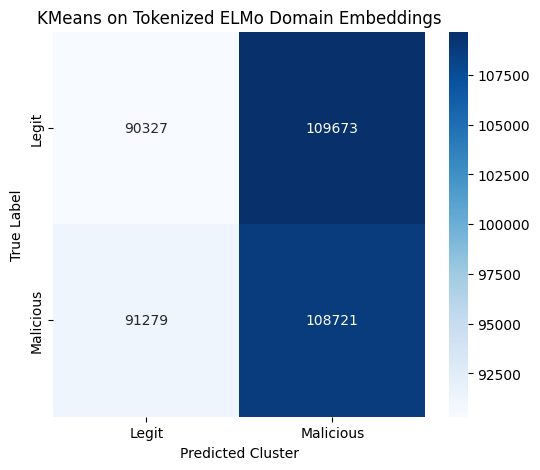

In [ ]:
cm = confusion_matrix(Testing_df['Label'], clusters)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit','Malicious'],
            yticklabels=['Legit','Malicious'])
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("KMeans on Tokenized ELMo Domain Embeddings")
plt.show()

In [ ]:
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)


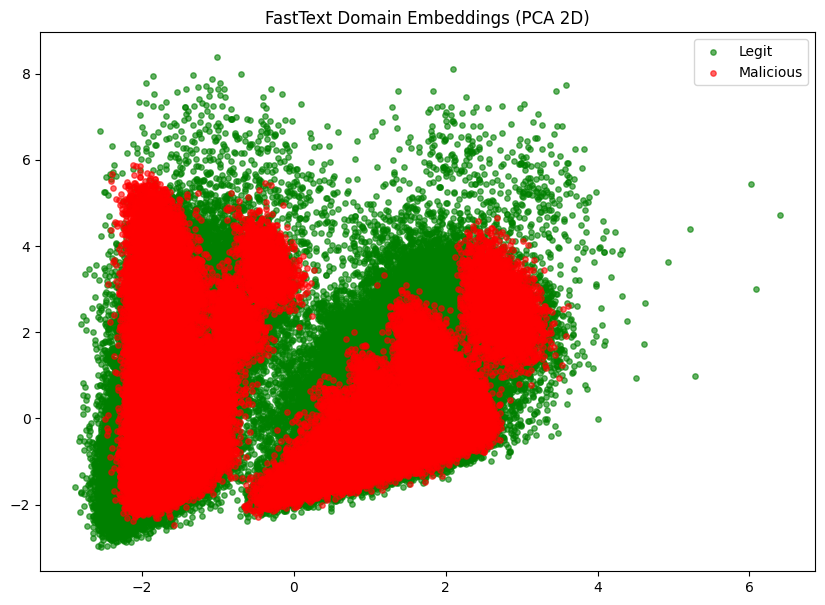

In [ ]:
# Plot
plt.figure(figsize=(10,7))

for label, color in [('Legit', 'green'), ('Malicious', 'red')]:
    idx = [i for i, l in enumerate(clean_labels) if l == label]
    plt.scatter(X_test_2d[idx,0], X_test_2d[idx,1], label=label, alpha=0.6, s=15, c=color)

plt.title("FastText Domain Embeddings (PCA 2D)")
plt.legend()
plt.show()

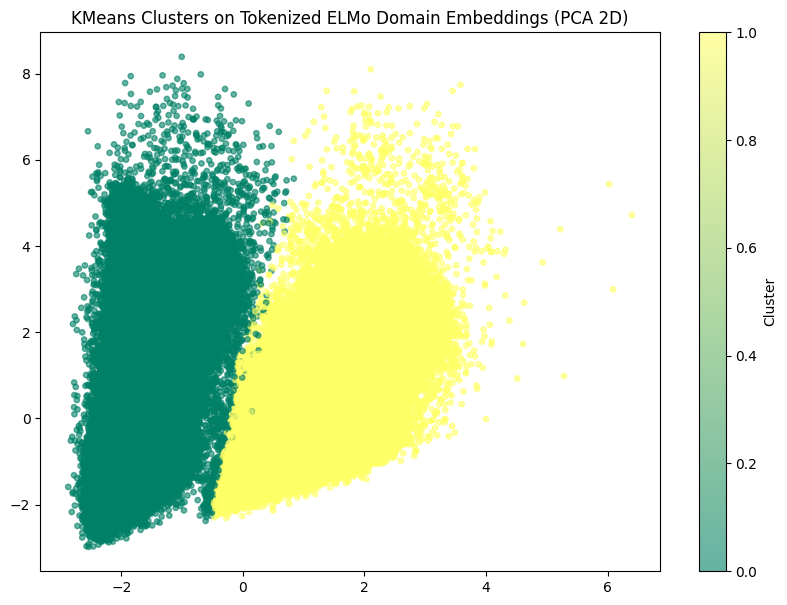

In [ ]:

plt.figure(figsize=(10,7))
plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=clusters, cmap='summer', alpha=0.6, s=15)
plt.title("KMeans Clusters on Tokenized ELMo Domain Embeddings (PCA 2D)")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
print(classification_report(Testing_df['Label'], clusters))

              precision    recall  f1-score   support

           0       0.50      0.45      0.47    200000
           1       0.50      0.54      0.52    200000

    accuracy                           0.50    400000
   macro avg       0.50      0.50      0.50    400000
weighted avg       0.50      0.50      0.50    400000



## Transformers (Bert) Embeddings

In [ ]:
Train_df, Validation_df = train_test_split(Training_df[['Domains', 'Label']], test_size=0.2, random_state=42, stratify=Training_df['Label'])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class DomainDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=32)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# test_dataset = DomainDataset(test_domains, y_test)


In [ ]:
def clean_domain(domain):
    domain = str(domain).lower().strip()              # lowercase & remove spaces
    domain = re.sub(r"^www\d*\.", "", domain)         # remove leading www / www2 etc.
    domain = re.sub(r"https?://", "", domain)         # remove http/https
    domain = re.sub(r"[^a-z0-9\.-]", "", domain)      # keep only alphanumeric, dot, dash
    domain = re.sub(r"\.{2,}", ".", domain)           # replace multiple dots with one
    return domain


In [ ]:
Train_df["Domains"] = Train_df["Domains"].apply(clean_domain)
Train_df

,Domains,Label
254477,1jqxiqt1o4qaf41nmfraciprzyf.net,__label__Malicious
423162,irbureau.com,__label__Legit
738857,keenandgraev.com,__label__Legit
963133,yufihlkmwenmdf.com,__label__Malicious
683672,glowmonkey.com,__label__Legit
...,...,...
90375,focfodnkfeflafff.com,__label__Malicious
81215,feadiwandat.kz,__label__Malicious
680916,thinkersfrfor.com,__label__Malicious
539254,snapetail.com,__label__Legit


In [ ]:
Validation_df["Domains"] = Validation_df["Domains"].apply(clean_domain)
Validation_df

,Domains,Label
177027,new-best.ws,__label__Legit
857279,listmuworkwhpubpropatthe.ru,__label__Malicious
329892,2y01xa1uzpnw3x8rydzctd4e.com,__label__Malicious
475676,universityscheduleshiftsmoke.com,__label__Malicious
215981,qkgguakkkcgyaksw.org,__label__Malicious
...,...,...
801773,palaalpitour.it,__label__Legit
236129,businesstrainingworks.com,__label__Legit
986572,wekgfpgrtuloyaa.ru,__label__Malicious
516617,heredis-online.com,__label__Legit


In [ ]:
def tokenize_domain(domain):
    tokens = re.split(r'[^a-z0-9]', domain)   # split on non-alphanumeric
    tokens = [t for t in tokens if t]         # remove empty tokens
    return " ".join(tokens)

In [ ]:
Train_df["Domains"] = Train_df["Domains"].apply(tokenize_domain)
Train_df

,Domains,Label
254477,1jqxiqt1o4qaf41nmfraciprzyf net,__label__Malicious
423162,irbureau com,__label__Legit
738857,keenandgraev com,__label__Legit
963133,yufihlkmwenmdf com,__label__Malicious
683672,glowmonkey com,__label__Legit
...,...,...
90375,focfodnkfeflafff com,__label__Malicious
81215,feadiwandat kz,__label__Malicious
680916,thinkersfrfor com,__label__Malicious
539254,snapetail com,__label__Legit


In [ ]:
Validation_df["Domains"] = Validation_df["Domains"].apply(tokenize_domain)
Validation_df

,Domains,Label
177027,new best ws,__label__Legit
857279,listmuworkwhpubpropatthe ru,__label__Malicious
329892,2y01xa1uzpnw3x8rydzctd4e com,__label__Malicious
475676,universityscheduleshiftsmoke com,__label__Malicious
215981,qkgguakkkcgyaksw org,__label__Malicious
...,...,...
801773,palaalpitour it,__label__Legit
236129,businesstrainingworks com,__label__Legit
986572,wekgfpgrtuloyaa ru,__label__Malicious
516617,heredis online com,__label__Legit


In [ ]:
label_map = {"__label__Legit": 0, "__label__Malicious":1}
Train_df["Label"] = Train_df["Label"].map(label_map)
Train_df

,Domains,Label
254477,1jqxiqt1o4qaf41nmfraciprzyf net,1
423162,irbureau com,0
738857,keenandgraev com,0
963133,yufihlkmwenmdf com,1
683672,glowmonkey com,0
...,...,...
90375,focfodnkfeflafff com,1
81215,feadiwandat kz,1
680916,thinkersfrfor com,1
539254,snapetail com,0


In [ ]:
Validation_df["Label"] = Validation_df["Label"].map(label_map)
Validation_df

,Domains,Label
177027,new best ws,0
857279,listmuworkwhpubpropatthe ru,1
329892,2y01xa1uzpnw3x8rydzctd4e com,1
475676,universityscheduleshiftsmoke com,1
215981,qkgguakkkcgyaksw org,1
...,...,...
801773,palaalpitour it,0
236129,businesstrainingworks com,0
986572,wekgfpgrtuloyaa ru,1
516617,heredis online com,0


In [ ]:
train_dataset = DomainDataset(Train_df["Domains"].tolist(), Train_df["Label"].tolist())

In [ ]:
validation_dataset  = DomainDataset(Validation_df["Domains"].tolist(), Validation_df["Label"].tolist())

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
# Replace path with your saved checkpoint
MODEL_PATH = "./results/checkpoint-best"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
base_model = AutoModel.from_pretrained(MODEL_PATH)
model.eval()

In [ ]:
def get_Bert_embeddings(texts, model):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=32, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encodings)
    # Mean pooling across tokens
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings


In [ ]:
X_test = get_Bert_embeddings(Testing_df['Domains'].tolist(), base_model)
X_test

In [ ]:
y_test = Testing_df['Label'].map(label_map).values
y_test

In [ ]:
# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_test)


In [ ]:
# PCA 2D
pca = PCA(n_components=2)
PCA_Embeddings = pca.fit_transform(X_test)

In [ ]:
plt.figure(figsize=(10,7))

for label, color in [('Legit', 'green'), ('Malicious', 'red')]:
    idx = [i for i, l in enumerate(clean_labels) if l == label]
    plt.scatter(PCA_Embeddings[idx,0], PCA_Embeddings[idx,1], label=label, alpha=0.6, s=15, c=color)

plt.title("FastText Domain Embeddings (PCA 2D)")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(PCA_Embeddings[:,0], PCA_Embeddings[:,1], c=clusters, cmap="coolwarm", alpha=0.6, s=15)
plt.title("Transformer Embeddings of Domains (PCA 2D)")
plt.show()

In [ ]:
cm = confusion_matrix(y_test, clusters)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legit","Malicious"], yticklabels=["Legit","Malicious"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, clusters))


## Variational AutoEncoder

What makes VAEs special is their ability to model data probabilistically, which means they don’t just learn compressed versions of data but learn to generate new data points from the latent distribution. [Latent Space Representation](https://medium.com/@whyamit101/latent-space-representations-in-variational-autoencoders-vaes-e74076eda77b)

In [ ]:
domains = Training_df["Domains"].astype(str).tolist()

In [ ]:
def generate_ngrams(domain, n_sizes=[2,3,4]):
    domain = domain.lower().replace('.', '')
    ngrams = []
    for n in n_sizes:
        ngrams += [domain[i:i+n] for i in range(len(domain)-n+1)]
    return ngrams

In [ ]:
all_ngrams = []
for domain in domains:
    all_ngrams += generate_ngrams(domain, n_sizes=[2,3,4])

ngram_counts = Counter(all_ngrams)
most_common_ngrams = [ngram for ngram, _ in ngram_counts.most_common(vocab_size)]
ngram2idx = {ng: i+1 for i, ng in enumerate(most_common_ngrams)}

In [ ]:
def encode_domain_ngrams(domain, ngram2idx, n_sizes=[2,3,4], max_len=20):
    ngrams = generate_ngrams(domain, n_sizes)
    seq = [ngram2idx.get(ng, 0) for ng in ngrams]
    if len(seq) < max_len:
        seq += [0]*(max_len-len(seq))
    else:
        seq = seq[:max_len]
    return seq

In [ ]:
encoded_domains = np.array([encode_domain_ngrams(d, ngram2idx, max_len=max_len) for d in domains])

In [ ]:
max_len = 20
vocab_size = len()
embed_dim = 32
latent_dim = 64

In [ ]:
encoded_domains

array([[217,  52, 188, ..., 944,   0,   0],
       [  0,   0, 312, ...,   0,   0,   0],
       [169,  83,  84, ...,   0, 990,   4],
       ...,
       [111, 260, 444, ...,   8, 445,  95],
       [157,   9,  92, ..., 745,   0, 464],
       [466,  81,   8, ..., 195, 372,   0]], shape=(1600000, 20))

### -------------------------------
### Sampling layer and KL Divergence layer
### -------------------------------

In [ ]:

class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class KLLossLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(kl, axis=1))
        self.add_loss(kl_loss)
        return inputs


### VAE Model

In [ ]:
from tensorflow.keras import layers, Model, Input

In [ ]:


# Encoder
inputs = Input(shape=(max_len,), name="encoder_input")
x = Embedding(input_dim=vocab_size+1, output_dim=embed_dim, input_length=max_len)(inputs)
x = Conv1D(64, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x)

x = Conv1D(32, 3, activation="relu", padding="same")(x)
x = MaxPooling1D(2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = LSTM(64)(x)
x = layers.LayerNormalization()(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# KL Loss Layer
z_mean, z_log_var = KLLossLayer()([z_mean, z_log_var])

# Latent space sampling
z = Sampling()([z_mean, z_log_var])

# Decoder
x = RepeatVector(max_len)(z)
x = LSTM(32, return_sequences=True)(x)
x = layers.LayerNormalization()(x)

decoded = Conv1D(vocab_size+1, 3, activation="softmax", padding="same", name="decoder_output")(x)

vae = Model(inputs, decoded, name="vae")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
def reconstruction_loss(y_true, y_pred):
    recon = sparse_categorical_crossentropy(y_true, y_pred)  # (batch, max_len)
    return tf.reduce_mean(tf.reduce_sum(recon, axis=1))

vae.compile(optimizer="adam", loss=reconstruction_loss)
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 20, 32)    │     32,032 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 20, 64)    │      6,208 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 10, 32)    │      6,176 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 5, 32)     │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32)     │        128 │ max_pooling1d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     24,832 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ lstm_4[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_loss_layer_2     │ [(None, 64),      │          0 │ z_mean[0][0],     │
│ (KLLossLayer)       │ (None, 64)]       │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 64)        │          0 │ kl_loss_layer_2[… │
│ (Sampling)          │                   │            │ kl_loss_layer_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 20, 64)    │          0 │ sampling_2[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 20, 32)    │     12,416 │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 32)    │         64 │ lstm_5[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 20, 1001)  │     97,097 │ layer_normalizat… │
│ (Conv1D)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 187,657 (733.04 KB)

 Trainable params: 187,465 (732.29 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath="/content/drive/MyDrive/MSC Work/RQ1/FastText_Model/vae_best_model.keras",   # Save best model
    monitor="loss",                    # Monitor training loss (or 'val_loss' if using validation data)
    save_best_only=True,               # Only save when model improves
    save_weights_only=False,           # Save full model (architecture + weights + optimizer)
    verbose=1
)


In [ ]:
# Train with checkpoint
history = vae.fit(
    encoded_domains, encoded_domains,
    epochs=20,
    batch_size=16,
    callbacks=[checkpoint_cb]
)

Epoch 1/20
 99997/100000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 85.9399
Epoch 1: loss improved from inf to 83.00735, saving model to /content/drive/MyDrive/MSC Work/RQ1/FastText_Model/vae_best_model.keras
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 1109s 11ms/step - loss: 85.9398
Epoch 2/20
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 80.7831
Epoch 2: loss improved from 83.00735 to 80.59942, saving model to /content/drive/MyDrive/MSC Work/RQ1/FastText_Model/vae_best_model.keras
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 1132s 11ms/step - loss: 80.7831
Epoch 3/20
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 80.1779
Epoch 3: loss improved from 80.59942 to 80.09566, saving model to /content/drive/MyDrive/MSC Work/RQ1/FastText_Model/vae_best_model.keras
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 1183s 12ms/step - loss: 80.1779
Epoch 4/20
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 79.9153
Epoch 4: loss improved from 80.09566 to 79.97251, saving model to /content/drive/MyDrive/M

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:   # if you added validation data
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()


In [ ]:
# Character vocabulary
chars = list(string.ascii_lowercase + string.digits + ".")


In [ ]:
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '.']

In [ ]:
chars = ['<PAD>', '<UNK>'] + chars  # include padding and unknown
print(chars)
char2idx = {c: i for i, c in enumerate(chars)}
idx2char = {i: c for c, i in char2idx.items()}

['<PAD>', '<UNK>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']


In [ ]:
char2idx

{'<PAD>': 0,
 '<UNK>': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '0': 28,
 '1': 29,
 '2': 30,
 '3': 31,
 '4': 32,
 '5': 33,
 '6': 34,
 '7': 35,
 '8': 36,
 '9': 37,
 '.': 38}

In [ ]:
idx2char

{0: '<PAD>',
 1: '<UNK>',
 2: 'a',
 3: 'b',
 4: 'c',
 5: 'd',
 6: 'e',
 7: 'f',
 8: 'g',
 9: 'h',
 10: 'i',
 11: 'j',
 12: 'k',
 13: 'l',
 14: 'm',
 15: 'n',
 16: 'o',
 17: 'p',
 18: 'q',
 19: 'r',
 20: 's',
 21: 't',
 22: 'u',
 23: 'v',
 24: 'w',
 25: 'x',
 26: 'y',
 27: 'z',
 28: '0',
 29: '1',
 30: '2',
 31: '3',
 32: '4',
 33: '5',
 34: '6',
 35: '7',
 36: '8',
 37: '9',
 38: '.'}

## Unsupervised

In [ ]:
# Save as plain text (one domain per line)
train_df['Legitimate Domain'].to_csv("/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains_train.txt", index=False, header=False)
test_df['Legitimate Domain'].to_csv("/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains_test.txt", index=False, header=False)

In [ ]:
model = fasttext.train_unsupervised(
    input="/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains_train.txt",
    model="skipgram",    # CBOW is also possible
    dim=100,             # embedding size
    minn=2, maxn=5       # use character n-grams (important for short text)
)

model.save_model("/content/drive/MyDrive/MSC Work/RQ1/FastText_Model/domain_embeddings.bin")

In [ ]:
# Load test domains
with open("/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains_test.txt") as f:
    test_domains = [line.strip() for line in f]

# Get embeddings
embeddings = np.array([model.get_word_vector(d) for d in test_domains])

In [ ]:
# Lowercase
Illegitimate_Domains_df['Domains'] = Illegitimate_Domains_df['Domains'].str.lower()

# Split
train2_df, test2_df = train_test_split(Illegitimate_Domains_df, test_size=0.2, random_state=42)



In [ ]:
# Save as plain text (one domain per line)
train2_df['Domains'].to_csv("/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains2_train.txt", index=False, header=False)
test2_df['Domains'].to_csv("/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains2_test.txt", index=False, header=False)

In [ ]:
model = fasttext.train_unsupervised(
    input="/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains2_train.txt",
    model="skipgram",    # CBOW is also possible
    dim=100,             # embedding size
    minn=2, maxn=5       # use character n-grams (important for short text)
)

model.save_model("/content/drive/MyDrive/MSC Work/RQ1/FastText_Model/domain2_embeddings.bin")

In [ ]:
# Load test domains
with open("/content/drive/MyDrive/MSC Work/RQ1/Dataset/Domains/domains2_test.txt") as f:
    test2_domains = [line.strip() for line in f]

# Get embeddings
embeddings2 = np.array([model.get_word_vector(d) for d in test2_domains])

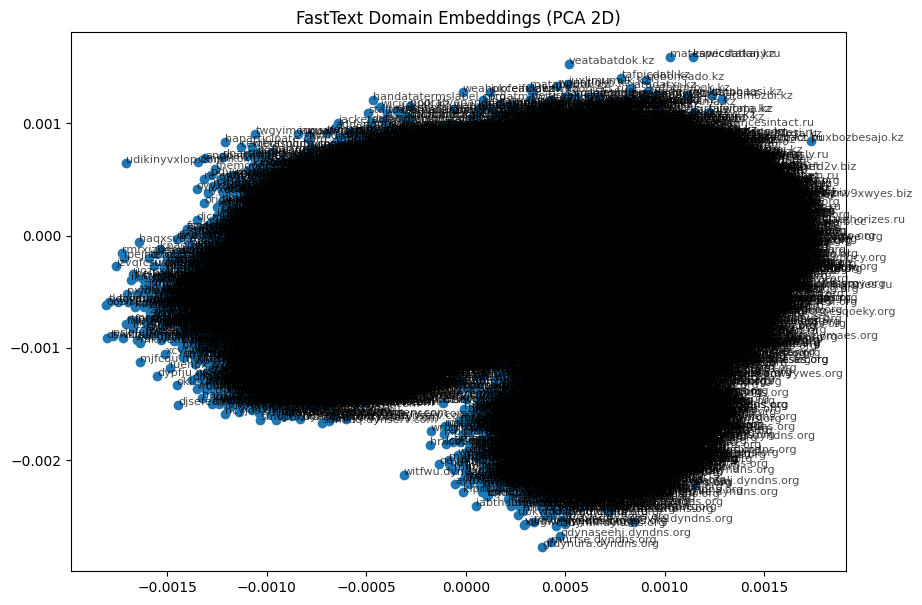

In [ ]:
# Reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings2)

plt.figure(figsize=(10,7))
plt.scatter(reduced[:,0], reduced[:,1])

for i, domain in enumerate(test_domains):
    plt.annotate(domain, (reduced[i,0], reduced[i,1]), fontsize=8, alpha=0.7)

plt.title("FastText Domain Embeddings (PCA 2D)")
plt.show()

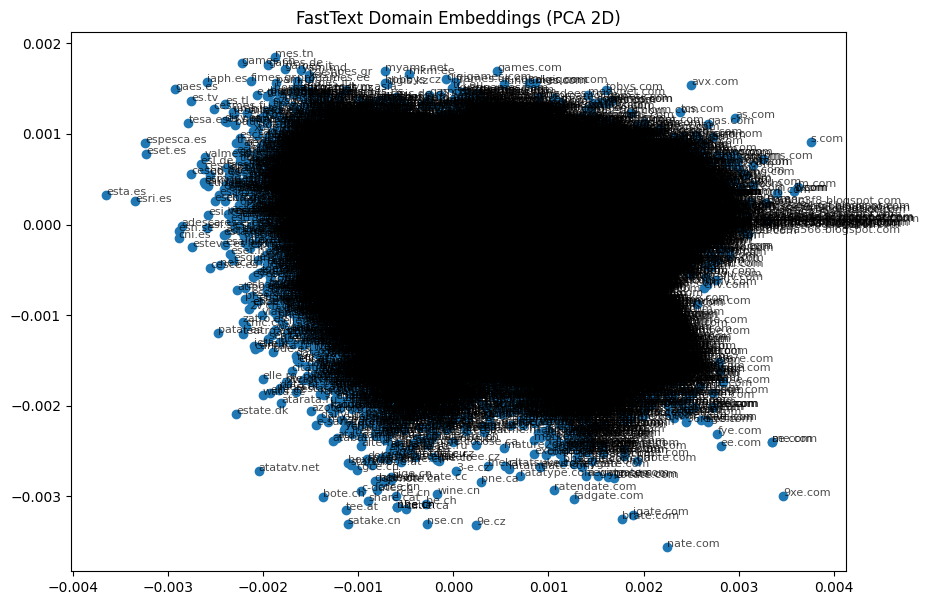

In [ ]:


# Reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10,7))
plt.scatter(reduced[:,0], reduced[:,1])

for i, domain in enumerate(test_domains):
    plt.annotate(domain, (reduced[i,0], reduced[i,1]), fontsize=8, alpha=0.7)

plt.title("FastText Domain Embeddings (PCA 2D)")
plt.show()
